In [13]:
import sys
sys.path.insert(0,'/home/idnm/Programming projects/jax_circuits')
from jax_circuits import *
from topology import *
from qiskit import QuantumCircuit
from qiskit.circuit.library import *


# Assembling

## Toffoli 5 without ancilla

We can find decomposition of Toffoli 5 without ancilla qubits using the following representation.

True


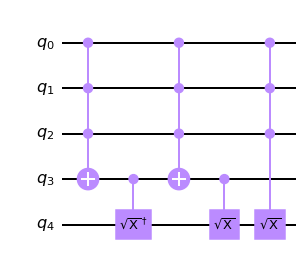

In [28]:
qc = QuantumCircuit(5)
qc.mct([0,1,2], 3)
qc.append(SXGate().inverse().control(1), [3,4])
qc.mct([0,1,2], 3)
qc.append(SXGate().control(1), [3,4])
qc.append(SXGate().control(3), [0,1,2,4])
print(jnp.allclose(Operator(qc.reverse_bits()).data, u_toff5))
qc.draw(output='mpl')

In place of Toffoli 4 gates proper one can use relative phase Toffoli gates (and also factor additional 3-qubit unitaries). Such a representation requires only 4 cz gates.

8.625


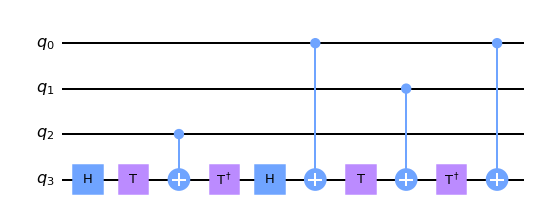

In [34]:
qc = QuantumCircuit(4)

qc.h(3)
qc.t(3)
qc.cx(2, 3)
qc.tdg(3)
qc.h(3)
qc.cx(0, 3)
qc.t(3)
qc.cx(1, 3)
qc.tdg(3)
qc.cx(0, 3)

u_toff4_relative_3q = Operator(qc.reverse_bits()).data
print(disc_modulo_diagonal(u_toff4, u_toff4_relative_3q, 4, [3]))
qc.draw(output='mpl')

4.375


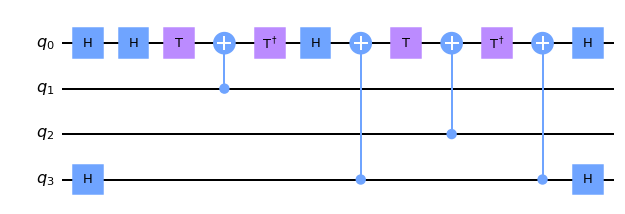

In [42]:
qc = QuantumCircuit(4)

qc.h(0)
qc.h(3)
qc.h(3)
qc.t(3)
qc.cx(2, 3)
qc.tdg(3)
qc.h(3)
qc.cx(0, 3)
qc.t(3)
qc.cx(1, 3)
qc.tdg(3)
qc.cx(0, 3)
qc = qc.reverse_bits()
qc.h(0)
qc.h(3)

u_toff4_relative_3q = Operator(qc.reverse_bits()).data
print(disc_modulo_diagonal(u_toff4, u_toff4_relative_3q, 4, [3]))
qc.draw(output='mpl')

# Decomposing

# Comparing